In [1]:
import torchvision.models as models
import torch
from torchvision import transforms
from PIL import Image
from torch.nn.utils.rnn import *
from torch import nn
from torch.utils import data
import time
import pdb
from torch.autograd import Variable

import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
GPU = torch.cuda.is_available()
device = torch.device("cuda" if GPU else "cpu")
cuda = torch.cuda.is_available()
num_workers = 0 if cuda else 0
GPU

True

In [3]:
torch.cuda.empty_cache()

# Reading Data

In [4]:
# Image loading hyperparameters
numDataPointsWanted = 33808     # max number is 33808
LOADIMAGES = False              # True if we want to pre-load all images (usually results in MEM errors)

CROPBOX = (0, 200, 640, 480)
IMG_SIZE = (320, 240)

transform = transforms.ToTensor()
root_path = "./"

def load_cropped_resized_image(filename):
    with Image.open(root_path + filename) as img:
         return transform(img.crop(CROPBOX).resize(IMG_SIZE).convert('RGB'))

if LOADIMAGES:
    print("Pre-loading all images..")
    X = np.zeros((numDataPointsWanted, 3, IMG_SIZE[0], IMG_SIZE[1]))
else:
    print("Loading image names only..")
    X = np.zeros((numDataPointsWanted), dtype=object)
Y = np.zeros((numDataPointsWanted, 3))


with open(root_path + "labels.txt") as f:
    start = time.time()
    i = 0
    for line in f:
        [filename, radians, torque, speed] = line.split(' ')

        if LOADIMAGES:
            X[i,:,:,:] = load_cropped_resized_image(filename)
        else:
            X[i] = filename
        Y[i,0] = (((float(radians) * 180.0) / np.pi))
        Y[i,1] = float(torque)
        Y[i,2] = float(speed)
        i += 1
            
        if i == numDataPointsWanted: break
    end = time.time()
    

print("Data loading complete, took", int(end - start), "seconds")
print('# Images loaded: ', len(X))

Loading image names only..
Data loading complete, took 0 seconds
# Images loaded:  33808


In [6]:
#trainX, valX, trainY, valY = train_test_split(X, Y, test_size=0.30)
split = int(0.7*len(X))
trainX = X[:split]
valX = X[split:]
trainY = Y[:split]
valY = Y[split:]
print(trainX.shape)

(23665,)


# Dataset

In [7]:
class Dataset(data.Dataset):
    def __init__(self, X, Y, seq_len, loaded_images):
        self.X = X
        self.Y = Y
        self.seq_len = seq_len
        self.loaded_images = loaded_images
        
    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, index):
        if not self.loaded_images:
            x = np.zeros((self.seq_len, 3, IMG_SIZE[1], IMG_SIZE[0]))
            for i in range(self.seq_len):
                x[i,:,:,:] = load_cropped_resized_image(self.X[index + i])
            return x, self.Y[index + self.seq_len - 1]
        return self.X[index:index + self.seq_len], self.Y[index + self.seq_len - 1]

In [8]:
BATCH_SIZE = 2
SEQ_LEN = 15
num_workers = 0 if cuda else 0

train_set = Dataset(trainX, trainY, SEQ_LEN, LOADIMAGES) #LOADIMAGES set to false
train_dataloader = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_set = Dataset(valX, valY, SEQ_LEN, LOADIMAGES)
val_dataloader = data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

### Example of cropped and resized image

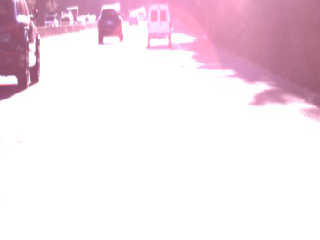

In [9]:
x = train_set.__getitem__(0)[0][0]
x = x.transpose(1, 2, 0)
Image.fromarray((x * 255).astype(np.uint8))

# Our Model


In [ ]:
import torch.nn as nn
import torch

In [11]:
class Whip(nn.Module):
    def __init__(self, in_channels, out_channels, input_size, output_size):
        super(Whip, self).__init__()
        
        self.conv1 = nn.Conv3d(in_channels=3, out_channels=64, kernel_size=(3, 12, 12), stride=(1,6,6), padding=(0,1,1))
        self.bn1 = nn.BatchNorm3d(64)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(2, 5, 5), stride=(1,2,2), padding=(0,0,0))
        self.bn2 = nn.BatchNorm3d(64)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(2, 5, 5), stride=(1,1,1), padding=(0,0,0))
        self.bn3 = nn.BatchNorm3d(64)
        self.relu3 = nn.ReLU()
        
        self.avgpool = nn.AvgPool3d(1)
        self.fc1 = nn.Linear(52*39*64, 128)
        self.fc2 = nn.Linear(24*18*64, 128)
        self.fc3 = nn.Linear(20*14*64, 128)

    def forward(self, x):
        batch_size=x.shape[0]
        
        output = self.conv1(x)
        output = self.bn1(output)
        output = self.relu1(output) 
        output1 = self.fc1(self.avgpool(output.permute(0,2,1,3,4)).reshape(batch_size,13,-1))
        
        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu2(output)
        output2 = self.fc2(self.avgpool(output.permute(0,2,1,3,4)).reshape(batch_size,12,-1))

        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)  #[batch, channels, seq_len, image H, image W]
        output3 = self.fc3(self.avgpool(output.permute(0,2,1,3,4)).reshape(batch_size,11,-1)) #batch, seq, 
        
        output1 = output1[:,:-2,:] #batch_size x 11 x 128, dropped last 2 time in sequence
        output2 = output2[:,:-1,:]
        output = output1 + output2 + output3  #batch 13 128
        return output

In [12]:
proto = Whip(15,13,27*37,128)
# print(proto)
dummy = torch.zeros([2,3,15,320,240])
result = proto.forward(dummy)
print(result.shape)

torch.Size([2, 11, 128])


### Prediction Sub-Network

In [13]:
class predictNet(nn.Module):
    def __init__(self, feature_dim=128, hidden_dim=64, out_dim=3, nlayers=3):
        super(predictNet,self).__init__()
        self.lstm = nn.LSTMCell(input_size=feature_dim+out_dim, hidden_size=hidden_dim, bias=False)
        self.fc = nn.Linear(feature_dim+hidden_dim+out_dim, out_dim)
    
    def forward(self, features): 
        predictions = []
        out = torch.zeros((features.shape[0],3)).to(device) #previous speed,torque,angle prediction
        for i in range(features.shape[1]):
            concat1 = torch.cat([features[:,i,:], out], dim=1) #[batch,seq_len,features]
            out_lstm, _ = self.lstm(concat1)
            concat2 = torch.cat([out_lstm, features[:,i,:], out], dim=1)
            out = self.fc(concat2) #[batch,3]
            
            predictions.append(out.unsqueeze(1))
        
        return torch.cat(predictions, dim=1)

In [14]:
class slimModel(nn.Module):
    def __init__(self, in_channels, out_channels, input_size, output_size=128, hidden_dim=64, out_dim=3, nlayers=3):
        super(slimModel, self).__init__()
        self.whip = Whip(in_channels, out_channels, input_size, output_size).to(device)
        self.predictNet = predictNet().to(device)
    
    def forward(self, x):
        features = self.whip(x)
        predictions = self.predictNet(features.to(device))
        return predictions

In [16]:
def combine(x, y):
    total = 0
    for v in range(len(x)):
        if x[v] and y[v]:
            total += 1
    return total

In [17]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss

In [18]:
angle_loss_weight = 10

def train(num_epochs, model, save, optimizer, scheduler, criterion, angle_loss_weight=10.0):
    EPOCH_TRAIN_LOSSES = []
    EPOCH_VAL_LOSSES = []
    EPOCH_TRAIN_ACC = []
    EPOCH_VAL_ACC = []
    train_a_acc = []
    val_a_acc = []
    
    
    for epoch in range(num_epochs):
        start = time.time()

        running_train_loss = 0.0
        running_val_loss = 0.0
        running_train_acc = 0.0
        running_val_acc = 0.0
               
        t_correct_predictions_0_5 = 0.0
        t_correct_predictions_1 = 0.0
        t_correct_predictions_2 = 0.0
        t_correct_predictions_5 = 0.0
        t_correct_predictions_g_5 = 0.0
        
        v_correct_predictions_0_5 = 0.0
        v_correct_predictions_1 = 0.0
        v_correct_predictions_2 = 0.0
        v_correct_predictions_5 = 0.0
        v_correct_predictions_g_5 = 0.0

        model.train()
        for i, (x, label) in enumerate(train_dataloader):
            x, label = x.to(device), label.to(device)
            optimizer.zero_grad()
            x = x.permute(0,2,1,3,4)
            y = model(x.float())[:,-1,:].double().squeeze(1)
            
#             loss = criterion(y, label)
            loss = angle_loss_weight * criterion(y[:,0], label[:,0]) / 4.0 + \
                                    criterion(y[:,1], label[:,1]) /0.9 + \
                                    criterion(y[:,2], label[:,2]) /2.4
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            predicted_angles = y[0]
            label_angles = label[0]
            running_train_acc += torch.mean(torch.abs(predicted_angles - label_angles)).item()
            t_correct_predictions_0_5 += torch.sum(torch.abs(predicted_angles - label_angles) <= 0.5).item()
            t_correct_predictions_1 += combine(torch.abs(predicted_angles - label_angles) > 0.5,  torch.abs(predicted_angles - label_angles) <= 1)
            t_correct_predictions_2 += combine(torch.abs(predicted_angles - label_angles) > 1,  torch.abs(predicted_angles - label_angles) <= 2)
            t_correct_predictions_5 += combine(torch.abs(predicted_angles - label_angles) > 2,  torch.abs(predicted_angles - label_angles) <= 5)
            v_correct_predictions_g_5 += torch.sum(torch.abs(predicted_angles - label_angles) > 5).item()
            
            del x
            del label

        train_a_a = [t_correct_predictions_0_5, t_correct_predictions_1, t_correct_predictions_2, t_correct_predictions_5, t_correct_predictions_g_5]
        train_a_acc.append(train_a_a)

        model.eval()
        with torch.no_grad():
            for i, (x, label) in enumerate(val_dataloader):
                x, label = x.to(device), label.to(device)
                x = x.permute(0,2,1,3,4)
                y = model(x.float())[:,-1,:].double().squeeze(1)
                
#                 loss = criterion(y, label)
                loss = angle_loss_weight * criterion(y[:,0], label[:,0]) /4.0 + \
                            criterion(y[:,1], label[:,1]) /0.9 + \
                            criterion(y[:,2], label[:,2]) /2.4

                running_val_loss += loss.item()
                predicted_angles = y[0]
                label_angles = label[0]
                running_val_acc += torch.mean(torch.abs(predicted_angles - label_angles)).item()
                v_correct_predictions_0_5 += torch.sum(torch.abs(predicted_angles - label_angles) <= 0.5).item()
                v_correct_predictions_1 += combine(torch.abs(predicted_angles - label_angles) > 0.5,  torch.abs(predicted_angles - label_angles) <= 1)
                v_correct_predictions_2 += combine(torch.abs(predicted_angles - label_angles) > 1,  torch.abs(predicted_angles - label_angles) <= 2)
                v_correct_predictions_5 += combine(torch.abs(predicted_angles - label_angles) > 2,  torch.abs(predicted_angles - label_angles) <= 5)
                v_correct_predictions_g_5 += torch.sum(torch.abs(predicted_angles - label_angles) > 5).item()
                
                del x
                del label
                
            val_a_a = [v_correct_predictions_0_5, v_correct_predictions_1, v_correct_predictions_2, v_correct_predictions_5, v_correct_predictions_g_5]
            val_a_acc.append(val_a_a)
                
        train_acc = running_train_acc / len(train_dataloader)
        val_acc = running_val_acc / len(val_dataloader)
        tloss = running_train_loss / len(train_dataloader)
        vloss = running_val_loss/ len(val_dataloader)

        print("EPOCH", epoch, "\t\tTook", int(time.time() - start), "s")
        print("Train Acc:", round(train_acc, 4), "\tVal Acc:", round(val_acc, 4))
        print("Avg Train Loss:", round(tloss, 4), "\tAvg Val Loss:", round(vloss, 4))
        print("===================================================================")

        scheduler.step(vloss)

        EPOCH_TRAIN_LOSSES.append(tloss)
        EPOCH_VAL_LOSSES.append(vloss)
        EPOCH_TRAIN_ACC.append(train_acc)
        EPOCH_VAL_ACC.append(val_acc)

        if save:
            torch.save(model.state_dict(), './model_' + str(epoch + 1) + '_' + str(val_acc) + '.pt')
            
    return EPOCH_TRAIN_LOSSES, EPOCH_VAL_LOSSES, EPOCH_TRAIN_ACC, EPOCH_VAL_ACC, val_a_acc, train_a_acc

for i, (x, label) in enumerate(train_dataloader):
    x, label = x.to(device), label.to(device)
    optimizer.zero_grad()
    y = model(x.float())[:,-1,:].double().squeeze(1)

    loss = criterion(y, label)
    import pdb; pdb.set_trace()

In [19]:
context_size = 15
out_channels = 13
# input_size = 140448     # use this if using original image size
input_size = 27*37

# we will be predicting angle, torque, and speed
output_size = 128
#model = Whip(context_size, out_channels, input_size, output_size).to(device)
# model = superModel(in_channels=context_size, out_channels=out_channels, input_size=input_size, output_size=128, hidden_dim=64, out_dim=3, nlayers=3)
# model = model.to(device)
model = slimModel(in_channels=context_size, out_channels=out_channels, input_size=input_size, output_size=128, hidden_dim=64, out_dim=3, nlayers=3)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
criterion = RMSELoss()

print(model)

slimModel(
  (whip): Whip(
    (conv1): Conv3d(3, 64, kernel_size=(3, 12, 12), stride=(1, 6, 6), padding=(0, 1, 1))
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv3d(64, 64, kernel_size=(2, 5, 5), stride=(1, 2, 2))
    (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (conv3): Conv3d(64, 64, kernel_size=(2, 5, 5), stride=(1, 1, 1))
    (bn3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU()
    (avgpool): AvgPool3d(kernel_size=1, stride=1, padding=0)
    (fc1): Linear(in_features=129792, out_features=128, bias=True)
    (fc2): Linear(in_features=27648, out_features=128, bias=True)
    (fc3): Linear(in_features=17920, out_features=128, bias=True)
  )
  (predictNet): predictNet(
    (lstm): LSTMCell(131, 64, bias=False)
    (fc): Linear(in_features=195, out_features=3, bias=True)
  )
)


In [20]:
EPOCH_TRAIN_LOSSES = []
EPOCH_VAL_LOSSES = []
EPOCH_TRAIN_ACC = []
EPOCH_VAL_ACC = []
val_a_acc = []
train_a_acc = []

In [21]:
n_epochs = 5
results = train(n_epochs, model, True, optimizer, scheduler, criterion)
EPOCH_TRAIN_LOSSES += results[0]
EPOCH_VAL_LOSSES += results[1]
EPOCH_TRAIN_ACC += results[2]
EPOCH_VAL_ACC += results[3]
val_a_acc += results[4]
train_a_acc += results[5]

EPOCH 0 		Took 4161 s
Train Acc: 6.6293 	Val Acc: 12.3133
Avg Train Loss: 39.1835 	Avg Val Loss: 44.3162
EPOCH 1 		Took 4122 s
Train Acc: 4.9957 	Val Acc: 4.5848
Avg Train Loss: 32.658 	Avg Val Loss: 19.4563
EPOCH 2 		Took 4114 s
Train Acc: 4.8729 	Val Acc: 4.5823
Avg Train Loss: 32.4517 	Avg Val Loss: 18.7813
EPOCH 3 		Took 4114 s
Train Acc: 4.9109 	Val Acc: 4.4977
Avg Train Loss: 32.2237 	Avg Val Loss: 18.5672
EPOCH 4 		Took 4115 s
Train Acc: 5.2064 	Val Acc: 4.5212
Avg Train Loss: 33.4827 	Avg Val Loss: 18.75


# Plotting Results

In [22]:
print(EPOCH_TRAIN_LOSSES)
print(EPOCH_VAL_LOSSES) 
print(EPOCH_TRAIN_ACC) 
print(EPOCH_VAL_ACC) 
print(val_a_acc) 
print(train_a_acc)

[39.1834840251116, 32.65799546525447, 32.4517107519005, 32.22372723972643, 33.482734674002344]
[44.31619700782354, 19.456289270737223, 18.78134070835926, 18.56724325686632, 18.750024618101797]
[6.62927176531399, 4.995674186654015, 4.872880317860087, 4.910855350789803, 5.2064144319155785]
[12.313318144074104, 4.58477919754078, 4.582290611957252, 4.497684579740437, 4.521237372890638]
[[630.0, 585.0, 1161.0, 3020.0, 21191.0], [3397.0, 2348.0, 1920.0, 2634.0, 14479.0], [3203.0, 2473.0, 2240.0, 2443.0, 14206.0], [3351.0, 2638.0, 1933.0, 2622.0, 14046.0], [3958.0, 2042.0, 1931.0, 2434.0, 14573.0]]
[[6256.0, 4891.0, 5794.0, 7139.0, 0.0], [6923.0, 5568.0, 6240.0, 7158.0, 0.0], [7178.0, 5740.0, 6220.0, 6964.0, 0.0], [7147.0, 5743.0, 6299.0, 6888.0, 0.0], [6553.0, 5294.0, 6426.0, 7456.0, 0.0]]


In [23]:
import matplotlib.pyplot as plt

ep = np.arange(n_epochs)

rangeVi = 0
rangeVf = n_epochs
plt.plot(ep[rangeVi:rangeVf], EPOCH_TRAIN_LOSSES[rangeVi:rangeVf], label="Train")
plt.plot(ep[rangeVi:rangeVf], EPOCH_VAL_LOSSES[rangeVi:rangeVf], label="Validation")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.legend()
plt.savefig('SlimModel LossGraph.png')
plt.show()

plt.plot(ep[rangeVi:rangeVf], EPOCH_TRAIN_ACC[rangeVi:rangeVf], label="Train")
plt.plot(ep[rangeVi:rangeVf], EPOCH_VAL_ACC[rangeVi:rangeVf], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Average Degree Distance")
plt.title("Epochs vs Average Degree Distance")
plt.legend()
plt.savefig('SlimModel AccuracyGraph.png')
plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

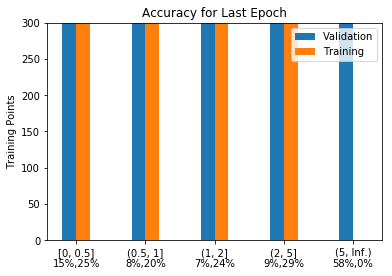

<Figure size 432x288 with 0 Axes>

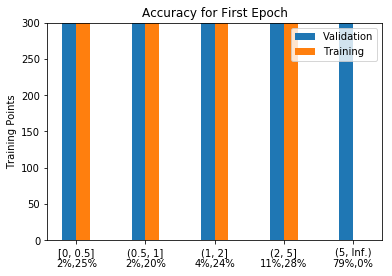

<Figure size 432x288 with 0 Axes>

In [24]:

objects = ('[0, 0.5]', '(0.5, 1]', '(1, 2]', '(2, 5]', '(5, Inf.)')
performanceV = val_a_acc[-1]
performanceT = train_a_acc[0]

x = np.arange(len(objects))
width = 0.2 # the width of the bars
ylim= 300#10000

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, performanceV, width, label="Validation")
rects1 = ax.bar(x + width/2, performanceT, width, label="Training")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Training Points')
ax.set_title('Accuracy for Last Epoch')
ax.set_xticks(x)
plt.ylim(0, ylim)
labels = []
totalV = sum(performanceV)
totalT = sum(performanceT)

for x in range(len(objects)):
    labels.append(objects[x] + "\n" + str(int((performanceV[x]/totalV)*100)) + "%," + str(int((performanceT[x]/totalT)*100)) + "%")
ax.set_xticklabels(labels)
ax.legend()
plt.show()
plt.savefig('SlimModel Last_Epoch.png', dpi=300)

objects = ('[0, 0.5]', '(0.5, 1]', '(1, 2]', '(2, 5]', '(5, Inf.)')
performanceV = val_a_acc[0]
performanceT = train_a_acc[-1]

x = np.arange(len(objects))
# print(v_all_a)
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, performanceV, width, label="Validation")
rects1 = ax.bar(x + width/2, performanceT, width, label="Training")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Training Points')
ax.set_title('Accuracy for First Epoch')
ax.set_xticks(x)
plt.ylim(0, ylim)
labels = []
totalV = sum(performanceV)
totalT = sum(performanceT)

for x in range(len(objects)):
    labels.append(objects[x] + "\n" + str(int((performanceV[x]/totalV)*100)) + "%," + str(int((performanceT[x]/totalT)*100)) + "%")
ax.set_xticklabels(labels)
ax.legend()
plt.show()
plt.savefig('SlimModel_Epoch.png', dpi=300)


In [26]:
torch.save(model.state_dict(), "SlimModel_5epoch.pt")